In [28]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import scipy.optimize as spo
import scipy.special as sps
import math
from matplotlib.gridspec import GridSpec

def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

def plaw_pspec_to_2pcf(const, delta):
    alpha = 3 - delta
    A = const * (sps.gamma(alpha/2))/ (np.power(2, 3/2 - alpha) * sps.gamma((3 - alpha)/2)) ## Change alert
    return A, alpha

def plaw_2pcf_to_pspec(A, alpha):
    delta = 3 - alpha
    const = A * (np.power(2, 3/2 - alpha) * sps.gamma((3 - alpha)/2)) / (sps.gamma(alpha/2))
    return const, delta

class clust_dist:
    def __init__(self, N_side, dx) -> None:
        self.N_side = N_side
        self.dx = dx
        #dk of the fourier lattice.
        self.dk = 2 * np.pi/(self.N_side * self.dx)

    def initialize_pois(self, n_bar):
        self.n_bar = n_bar
        
        #Creating a box with N_side^3 dimension and fill it with poisson random numbers with lambda=n_bar.
        self.box_p = np.random.poisson(lam=n_bar, size=(self.N_side, self.N_side, self.N_side))
        print("Poisson lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - n_bar)/n_bar
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals = temp_k_vals
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")

    def initialize_gauss(self, lam, sig):
        self.n_bar = lam

        #Creating a box with N_side^3 dimension and fill it with Gaussian random numbers with lambda=lam and sigma = sig.
        self.box_p = np.random.normal(loc=lam, scale=sig, size=(self.N_side, self.N_side, self.N_side))
        print("Gaussian lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - lam)/lam
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")
    
    def calc_powerspec_pois(self, k_intervals):
        #Finding the powerspectrum here. Iterate through the k_for_P and find the index of modk_grid with k
        #that falls between and find power spectrum pk.
        powerspec = np.zeros(len(k_intervals)-1)
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            powerspec[i] = np.average(np.absolute(self.box_delk[np.where((self.modk_grid > k1) & (self.modk_grid <= k2))]) ** 2)
        powerspec = powerspec/((self.N_side * self.dx)**3) * np.power(np.sqrt(2 * np.pi), 3)

        return powerspec
    
    def calc_powerspec_clust(self, k_intervals):
        powerspec = np.zeros(len(k_intervals)-1)
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            powerspec[i] = np.average(np.absolute(self.box_delk_clust[np.where((self.modk_grid > k1) & (self.modk_grid <= k2))]) ** 2)
        powerspec = powerspec/((self.N_side * self.dx)**3) * np.power(np.sqrt(2 * np.pi), 3)

        return powerspec
    
    def update_k_intervals(self, k_intervals):
        ##Assert that the given k_intervals have appropriate k_min and k_max
        assert k_intervals[0] == self.k_min
        # assert k_intervals[-1] == self.k_max
        #updating the k_intervals
        self.k_intervals = np.copy(k_intervals)
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)

    def make_clust_dist(self, powerspec_clust, k_intervals):
        #Making the new box_delk_clust. Right now, whenever we call this method, the previous box_delk_clust if any
        #will be erased.
        self.box_delk_clust = np.copy(self.box_delk)
        #Modifying the box-delk_clust to have the input powerspectrum.
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            temp_ind = np.where((self.modk_grid > k1) & (self.modk_grid <= k2))
            self.box_delk_clust[temp_ind] = self.box_delk[temp_ind] * (np.sqrt(powerspec_clust[i] + self.powerspec_pois[i])) / np.sqrt(self.powerspec_pois[i])
        #Defining the input powerspec as the powerspec of box_delk_clust
        
        self.powerspec_clust = np.copy(powerspec_clust)
        self.update_k_intervals(k_intervals)
        #Now we need to inverse fourier transfor box_delk_clust to get box_delx_clust
        self.box_delx_clust = np.fft.ifftn(self.box_delk_clust, norm='ortho')
        temp_factor = np.power(self.dk * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delx_clust = temp_factor * self.box_delx_clust
        #Create the new n(x) array.
        self.box_GN = self.n_bar * (1 + self.box_delx_clust)
        print("Made the clustered distribution.")

    def make_clust_dist_from_plaw_pspec(self, const, delta, k_intervals):
        self.const_of_pk = const
        self.delta_of_pk = delta
        if not np.array_equal(k_intervals, self.k_intervals):
            self.update_k_intervals(k_intervals)
        temp_pk = const * np.power(self.k_intervals_mid, -delta)
        self.make_clust_dist(temp_pk, self.k_intervals) 

    def calc_2pcorrfunc_clust(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_pix = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = self.x_intervals_pix * self.dx #I chose only even
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(self.x_intervals_pix):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")

    def calc_2pcorrfunc_clust_ax2(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_pix = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = self.x_intervals_pix * self.dx #I chose only even
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(self.x_intervals_pix):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:self.N_side-temp_x,:]) * (self.box_delx_clust[:,temp_x:,:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")

    def calc_2pcorrfunc_clust_ax3(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_pix = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = self.x_intervals_pix * self.dx #I chose only even
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(self.x_intervals_pix):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:,:self.N_side-temp_x]) * (self.box_delx_clust[:,:,temp_x:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")        

    def calc_2pcorrfunc_clust2(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)

        box_r = np.random.poisson(lam=self.n_bar, size=(self.N_side, self.N_side, self.N_side))
        bins = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = (bins[:-1] + bins[1:])/2 * self.dx
        x1, y1, z1 = np.asarray(np.meshgrid(np.arange(self.N_side), np.arange(self.N_side), np.arange(self.N_side), indexing='xy'), dtype='float')
        x1 = x1.flatten()
        y1 = y1.flatten()
        z1 = z1.flatten()
        weights1 = np.asarray(self.box_GN.flatten(), dtype='float')

        result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

        weights2 = np.asarray(box_r.flatten(), dtype='float')
        x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(self.N_side), np.arange(self.N_side), np.arange(self.N_side), indexing='xy'), dtype='float')
        x_r = x_r.flatten()
        y_r = y_r.flatten()
        z_r = z_r.flatten()
        result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

        result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)
        #Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
        #We need normalisation also, which is the total number of pairs.
        DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
        DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
        RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
        DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
        RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
        DR_total_GN = (np.sum(weights1) * np.sum(weights2))

        self._2pcorrfunc = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)


    def fit_2pcf_clust(self):
        temp_popt, temp_pcov = spo.curve_fit(pow_func, self.x_intervals_mid, self._2pcorrfunc)
        self._2pcf_fit_alpha = temp_popt[1]
        self._2pcf_fit_A = temp_popt[0]
        print("The measured 2pcf of box_delx_clust is fitted to a power law")

    def show_delx_dist(self):
        fig, ax = plt.subplots()
        ax.hist((self.box_delx_clust).flatten(), bins=100)
        ax.hist((self.box_delx).flatten(), bins=100)
        return fig, ax
    
    def show_powerspecs(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
        ax1.plot(self.k_intervals_mid, self.powerspec_pois, '-*', label="Measured")
        ax1.set_ylabel(r'$P(K)$')
        ax1.set_xlabel(r'$k$')
        ax1.set_title('power spectrum of poisson lattice')
        ax1.axhline((1/self.n_bar) * (self.dx / np.sqrt(2 * np.pi))**3, color ='k', label="expected")

        ax2.plot(self.k_intervals_mid, self.calc_powerspec_clust(self.k_intervals), '-*', label="measured")
        ax2.plot(self.k_intervals_mid, self.const_of_pk*np.power(self.k_intervals_mid, -self.delta_of_pk), '-*', label="input")
        # ax2.plot(self.k_intervals_mid, self.powerspec_clust, '-*', label="input")
        ax2.set_ylabel(r'$P(K)$')
        ax2.set_xlabel(r'$k$')
        ax2.set_title('power spectrum of clustered lattice')
        ax1.legend()
        ax2.legend()
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        return fig, (ax1, ax2)    
    
class incomp_dist(clust_dist):
    def initiate_incomp_eff(self):
        self.incomp_map = np.ones_like(self.box_GN)
        self.incomp_box_GN = np.copy(self.box_GN)
        print("Incompleteness effect initiated")

    def apply_incomp_map(self):
        self.incomp_box_GN = self.incomp_box_GN * self.incomp_map
        self.incomp_box_delx_clust = (self.incomp_box_GN - self.n_bar)/self.n_bar
        print("Incompleteness map applied")

    def calc_2pcorrfunc_incomp(self):
        #We use the same x intervals as the clust 2pcf
        self._2pcorrfunc_incomp = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(self.x_intervals_pix):
            self._2pcorrfunc_incomp[i] = np.sum((self.incomp_box_delx_clust[:self.N_side-temp_x,:,:]) * (self.incomp_box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
            self._2pcorrfunc_incomp[i] = self._2pcorrfunc_incomp[i]/(np.sum(self.incomp_map[:self.N_side-temp_x,:,:] * self.incomp_map[temp_x:,:,:])/ (self.N_side**3))
        print("2 point correlation function of incomplete dist calculated.")

    def fit_2pcf_clust_incomp(self):
        temp_popt, temp_pcov = spo.curve_fit(pow_func, self.x_intervals_mid, self._2pcorrfunc_incomp)
        self._2pcf_fit_alpha_incomp = temp_popt[1]
        self._2pcf_fit_A_incomp = temp_popt[0]
        print("The measured 2pcf of box_delx_clust is fitted to a power law")

In [51]:
N_side = 256
dx = 1
n_bar = 100
const_of_pk = 409.5
delta_of_pk = 1.0

sample_clust = clust_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)

sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 

sample_clust.calc_2pcorrfunc_clust(1.0 * dx, 50 * dx)

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_2149928/2180856099.py:151: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.


In [52]:
print("Is {} equal to {}".format(1/(sample_clust.n_bar/sample_clust.dx**3), np.sum(np.absolute(sample_clust.box_delk.flatten())**2) 
      * (sample_clust.dk)**3 * np.sqrt(2 * np.pi)**3 / (sample_clust.N_side * sample_clust.dx)**3))

Is 0.01 equal to 0.15749247963758609


In [54]:
np.sqrt(2*np.pi) ** 3

15.749609945722415

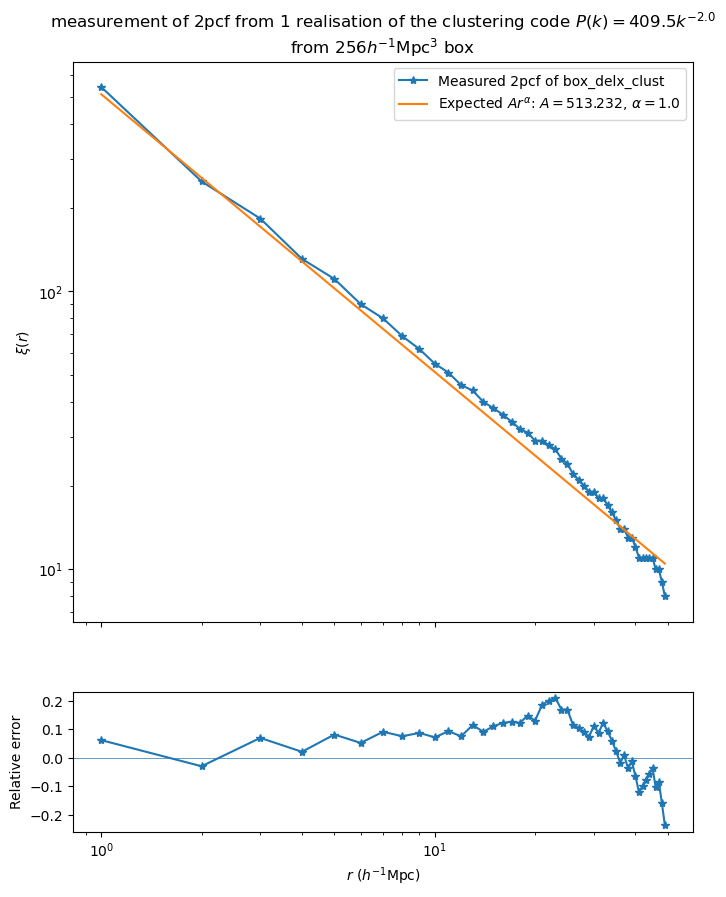

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), height_ratios=(8,2), sharex=True)
ax1.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*-', label="Measured 2pcf of box_delx_clust")
exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)
temp_exp_corr = exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha)
ax1.plot(sample_clust.x_intervals_mid, temp_exp_corr, \
            label=r"Expected $Ar^{{\alpha}}$: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel(r'$r$ ($h^{-1}$Mpc)')
ax1.set_ylabel(r'$\xi(r)$')
ax1.legend()
ax1.set_title(r"measurement of 2pcf from 1 realisation of the clustering code $P(k) = {}k^{{-{}}}$".format(sample_clust.const_of_pk, sample_clust.delta_of_pk) +
              "\n" + r"from 256$h^{-1}$Mpc$^3$ box")
ax2.set_ylabel(r"Relative error")
ax2.plot(sample_clust.x_intervals_mid, (sample_clust._2pcorrfunc-temp_exp_corr)/temp_exp_corr, '*-', label = "Measured, k-smoothed")
ax2.axhline(0, lw=0.5)

/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(0.0, 100.0)

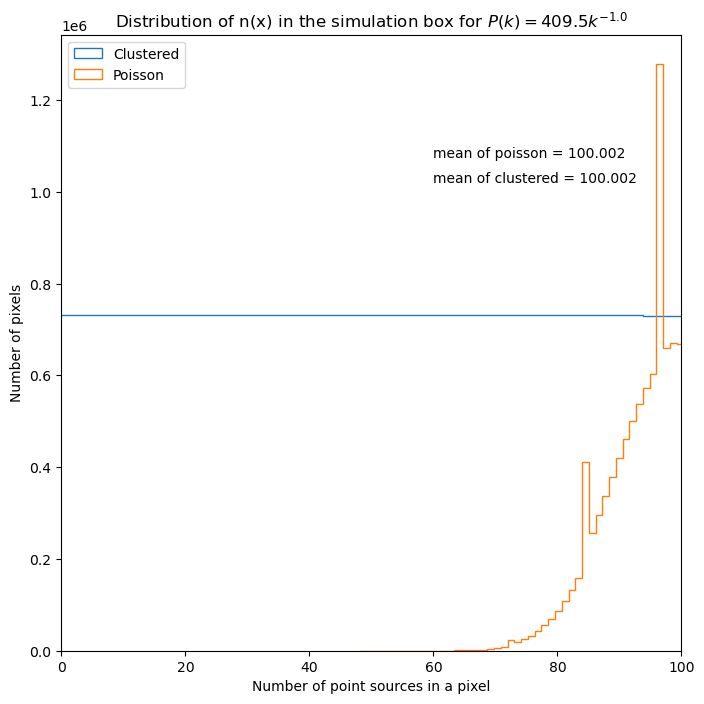

In [45]:
plt.figure(figsize=(8,8))
plt.hist(sample_clust.box_GN.flatten(), bins=100, label="Clustered", histtype='step')
plt.hist(sample_clust.box_p.flatten(), bins=100, label="Poisson", histtype='step');
plt.xlabel("Number of point sources in a pixel")
plt.ylabel("Number of pixels")
plt.legend()
plt.title(r"Distribution of n(x) in the simulation box for $P(k) = {}k^{{-{}}}$".format(sample_clust.const_of_pk, sample_clust.delta_of_pk))
plt.text(0.6, 0.8, "mean of poisson = "+str(np.round(np.mean(sample_clust.box_p.flatten()),3)), transform=plt.gca().transAxes)
plt.text(0.6, 0.76, "mean of clustered = "+str(np.round(np.absolute(np.mean(sample_clust.box_GN.flatten())),3)), transform=plt.gca().transAxes)
plt.xlim(0, 100)

(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'power spectrum of poisson lattice'}, xlabel='$k$', ylabel='$P(K)$'>,
  <Axes: title={'center': 'power spectrum of clustered lattice'}, xlabel='$k$', ylabel='$P(K)$'>))

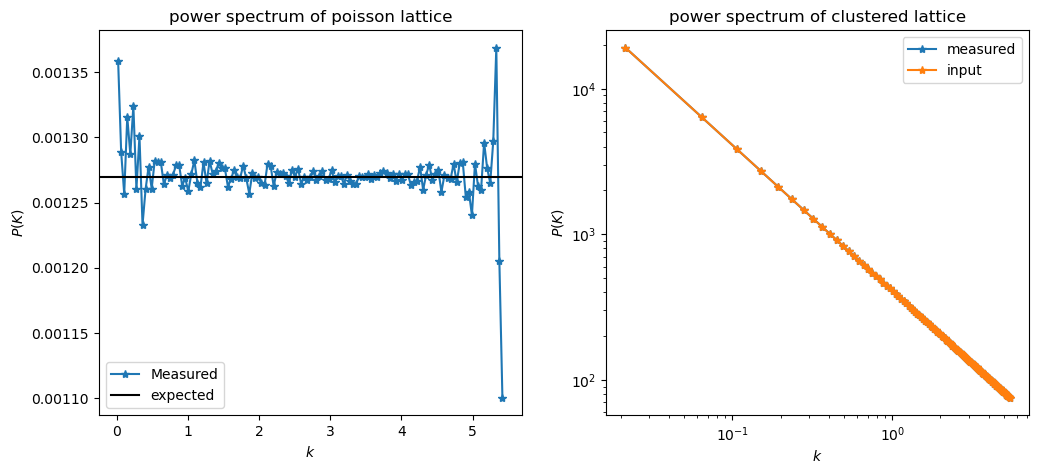

In [32]:
sample_clust.show_powerspecs()

In [33]:
sample_clust.dk

0.02454369260617026

In [34]:
sample_clust.dx

1